In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [3]:
features_df = pd.read_csv('../data/processed/features.csv')

In [28]:
from sklearn.preprocessing import LabelEncoder
X = features_df.drop('label', axis=1).values  # features
y = features_df['label'].values  # target variable
le = LabelEncoder()
y = le.fit_transform(y)
X.shape, y.shape

((17579, 24), (17579,))

## Logistic Regression Pipeline with Hyperparameter Tuning and Cross-Validation

In [16]:
# Define a pipeline that includes scaling and the classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression())
])

# Parameters to search
param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['liblinear']
}

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='accuracy')

# MLflow experiment setup
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("ECG_Heart_Rhythm_Classification")

# Start MLflow run
with mlflow.start_run(run_name="Logistic Regression"):
    # Execute the grid search
    grid_search.fit(X, y)

    # Best model and its parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    # Perform KFold cross-validation
    cv_scores = cross_val_score(best_model, X, y, cv=kf, scoring='accuracy')
    
    # Log parameters and metrics
    mlflow.log_params(best_params)
    mlflow.log_metric("cv_accuracy_mean", cv_scores.mean())
    mlflow.log_metric("cv_accuracy_std", cv_scores.std())
    
    # Log the best model
    mlflow.sklearn.log_model(best_model, "model")

    print(f"Best Parameters: {best_params}")
    print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


/Users/ajaykarthicksenthilkumar/miniconda/envs/ecg_proj_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ajaykarthicksenthilkumar/miniconda/envs/ecg_proj_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ajaykarthicksenthilkumar/miniconda/envs/ecg_proj_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/ajaykarthicksenthilkumar/miniconda/envs/ecg_proj_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best Parameters: {'logreg__C': 10, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
CV Accuracy: 0.6957 (+/- 0.0043)


/Users/ajaykarthicksenthilkumar/miniconda/envs/ecg_proj_env/lib/python3.9/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ajaykarthicksenthilkumar/miniconda/envs/ecg_proj_env/lib/python3.9/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Fit the best model on the training set
best_model.fit(X_train, y_train)

/Users/ajaykarthicksenthilkumar/miniconda/envs/ecg_proj_env/lib/python3.9/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=10, penalty='l1', solver='liblinear'))])

In [19]:
# Predict the test set
y_pred = best_model.predict(X_test)

In [20]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7022


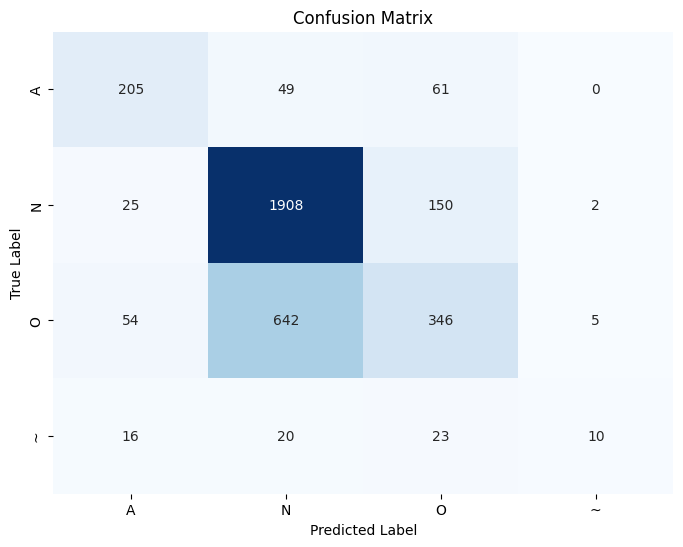

In [21]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Classification report
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

           A       0.68      0.65      0.67       315
           N       0.73      0.92      0.81      2085
           O       0.60      0.33      0.43      1047
           ~       0.59      0.14      0.23        69

    accuracy                           0.70      3516
   macro avg       0.65      0.51      0.53      3516
weighted avg       0.68      0.70      0.67      3516



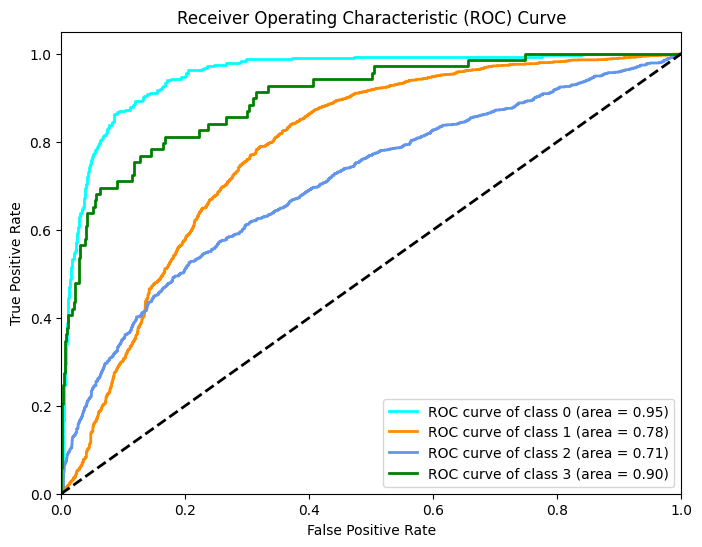

In [34]:

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

# Binarize the output for the entire dataset before train-test split
y = label_binarize(y, classes=[0, 1, 2, 3])
n_classes = y.shape[1]

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Assuming best_model is a model instance from GridSearchCV or similar
classifier = OneVsRestClassifier(best_model)
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

mlflow.end_run()
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("ECG_Heart_Rhythm_Classification")
with mlflow.start_run(run_name="Logistic Regression"):
    for i in range(n_classes):
        mlflow.log_metric(f"roc_auc_class_{i}", roc_auc[i])
        
    # Calculate and log the mean ROC AUC
    mean_roc_auc = np.mean(list(roc_auc.values()))
    mlflow.log_metric("mean_roc_auc", mean_roc_auc)

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
    label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


#### Class Distribution
- **Normal (N)**: The majority class with the highest number of samples.
- **Atrial Fibrillation (A)**: A smaller, yet significant number of cases.
- **Other Rhythms (O)**: Fewer instances than the Normal class but more than the Noisy recordings.
- **Noisy (~)**: The least represented class in the dataset.

This distribution suggests a class imbalance, which can impact model training and evaluation. Specifically, the model may tend to favor the majority class (Normal) due to its higher prevalence.

#### Receiver Operating Characteristic (ROC) Curve

The ROC curves for each class provide insight into the model's ability to distinguish between classes:

- **Class 0 (Atrial Fibrillation (A))**: The model performs excellently in classifying Atrial Fibrillation with an AUC of 0.95, indicating a high true positive rate and a low false positive rate.
- **Class 1 (Normal (N))**: The model shows good predictive accuracy with an AUC of 0.78, which is commendable but suggests there is room for improvement, especially given the class imbalance.
- **Class 2 (Other Rhythms (O))**: With an AUC of 0.71, the model has fair predictive accuracy. The overlap with other classes in the distribution may contribute to the lower AUC.
- **Class 3 (Noise (~))**: Despite being the least represented class, the model achieves an AUC of 0.90, indicating strong performance, likely due to distinctive features of noisy recordings that make them easier to identify.

### Overall Interpretation

The model shows varying levels of predictive accuracy across different classes. The high performance on Atrial Fibrillation and Noisy recordings is particularly notable. However, the relatively lower AUC for the Normal and Other Rhythms classes suggests that improvements can be made, possibly by addressing the class imbalance or fine-tuning the model to better capture the nuances of these classes.

Given the class imbalance, it is crucial to consider metrics beyond accuracy, such as precision, recall, and the F1 score, to truly understand the model's performance. Techniques such as resampling, cost-sensitive learning, or anomaly detection methods could potentially improve model performance, especially for underrepresented classes.

Moreover, the good performance on the Noisy class (~) indicates the model's effectiveness at identifying noise, which is beneficial for pre-processing stages of ECG analysis pipelines where noise removal is critical.

To further enhance the model, feature engineering, model ensemble techniques, or advanced algorithms could be explored. Additionally, the application of calibration methods or threshold-moving strategies based on ROC analysis might optimize the decision boundary for each class, thereby improving the overall classification results in a clinically meaningful way.

### Conclusion

The analysis indicates that while the model is quite robust in identifying clear cases of Atrial Fibrillation and Noisy recordings, it requires further refinement for more accurate classification of Normal and Other Rhythms. This refinement should account for the class imbalance and consider the clinical implications of misclassifications, particularly false negatives in Atrial Fibrillation detection, which could have serious health consequences for patients.

